In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-07 21:43:08--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.170.101, 16.182.38.168, 16.182.98.144, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.170.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  19.5MB/s    in 0.7s    

2024-04-07 21:43:09 (19.5 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


Importing the DataSet

In [ ]:
import os
filename = os.path.join("jena_climate_2009_2016.csv")

with open(filename) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


parsing the data

In [ ]:
import numpy as np
temperatures = np.zeros((len(lines),))
rawdata = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperatures[i] = values[1]
    rawdata[i, :] = values[:]

plotting the timeseries of a temperature

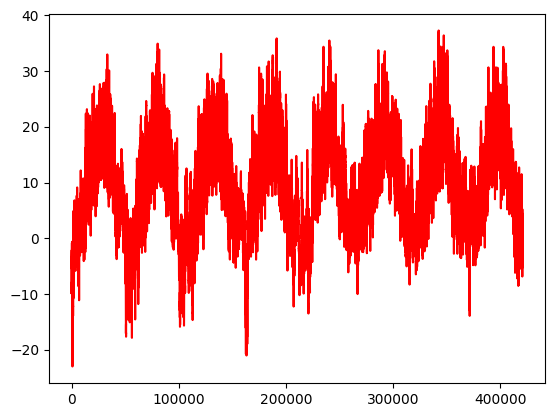

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperatures)), temperatures, color='red')

plotting for the first 15days timeseries for a temperature

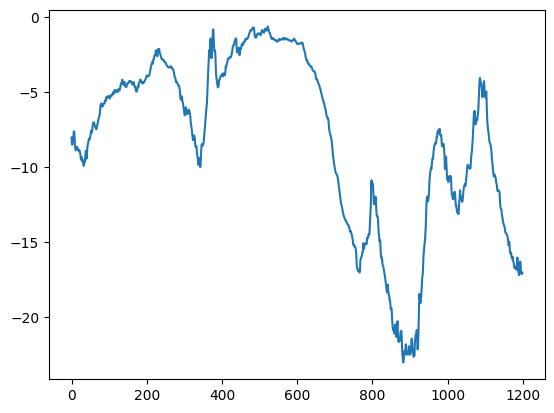

In [ ]:
plt.plot(range(1200), temperatures[:1200])

 Number of samples we'll use for each data split

In [ ]:
number_train_samples = int(0.5 * len(rawdata))
number_val_samples = int(0.25 * len(rawdata))
number_test_samples = len(rawdata) - number_train_samples - number_val_samples
print("number_train_samples:", number_train_samples)
print("number_val_samples:", number_val_samples)
print("number_test_samples:", number_test_samples)

number_train_samples: 210225
number_val_samples: 105112
number_test_samples: 105114


 Normalizing the data

In [ ]:
mean = rawdata[:number_train_samples].mean(axis=0)
rawdata -= mean
std = rawdata[:number_train_samples].std(axis=0)
rawdata /= std

In [ ]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummydataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummydataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256


In [ ]:
train_dataset = keras.utils.timeseries_dataset_from_array(
    rawdata[:-delay],
    targets=temperatures[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=number_train_samples)

In [ ]:
val_dataset = keras.utils.timeseries_dataset_from_array(
    rawdata[:-delay],
    targets=temperatures[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=number_train_samples,
    end_index=number_train_samples + number_val_samples)

In [ ]:
test_dataset = keras.utils.timeseries_dataset_from_array(
    rawdata[:-delay],
    targets=temperatures[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=number_train_samples + number_val_samples)

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


Non-machine-learning baseline

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


Training and evaluating a densely connected model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, rawdata.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 10s 10ms/step - loss: 13.2909 - mae: 2.8160 - val_loss: 11.4993 - val_mae: 2.6673
Epoch 2/10
819/819 [==============================] - 8s 10ms/step - loss: 9.3378 - mae: 2.4045 - val_loss: 13.3769 - val_mae: 2.8934
Epoch 3/10
819/819 [==============================] - 8s 10ms/step - loss: 8.5710 - mae: 2.3077 - val_loss: 10.4705 - val_mae: 2.5582
Epoch 4/10
819/819 [==============================] - 8s 10ms/step - loss: 8.0599 - mae: 2.2383 - val_loss: 10.7395 - val_mae: 2.5863
Epoch 5/10
819/819 [==============================] - 8s 10ms/step - loss: 7.6390 - mae: 2.1809 - val_loss: 11.2260 - val_mae: 2.6423
Epoch 6/10
819/819 [==============================] - 8s 10ms/step - loss: 7.3684 - mae: 2.1421 - val_loss: 10.6419 - val_mae: 2.5842
Epoch 7/10
819/819 [==============================] - 8s 10ms/step - loss: 7.1353 - mae: 2.1076 - val_loss: 12.1017 - val_mae: 2.7486
Epoch 8/10
819/819 [==============================] - 8s 10m

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 flatten (Flatten)           (None, 1680)              0         
                                                                 
 dense (Dense)               (None, 16)                26896     
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 26913 (105.13 KB)
Trainable params: 26913 (105.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


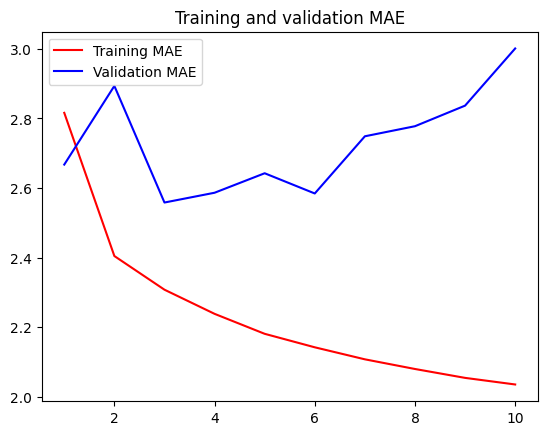

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "r", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

1D Convolution model

In [ ]:
inputs = keras.Input(shape=(sequence_length, rawdata.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 12s 11ms/step - loss: 21.1561 - mae: 3.6263 - val_loss: 16.9556 - val_mae: 3.2452
Epoch 2/10
819/819 [==============================] - 8s 10ms/step - loss: 15.5420 - mae: 3.1321 - val_loss: 16.5664 - val_mae: 3.2358
Epoch 3/10
819/819 [==============================] - 8s 10ms/step - loss: 14.5533 - mae: 3.0309 - val_loss: 14.7408 - val_mae: 3.0336
Epoch 4/10
819/819 [==============================] - 8s 10ms/step - loss: 13.8662 - mae: 2.9563 - val_loss: 15.2007 - val_mae: 3.0966
Epoch 5/10
819/819 [==============================] - 8s 10ms/step - loss: 13.3018 - mae: 2.8961 - val_loss: 16.9790 - val_mae: 3.2418
Epoch 6/10
819/819 [==============================] - 8s 10ms/step - loss: 12.7916 - mae: 2.8398 - val_loss: 15.6116 - val_mae: 3.1159
Epoch 7/10
819/819 [==============================] - 8s 10ms/step - loss: 12.3280 - mae: 2.7858 - val_loss: 15.6727 - val_mae: 3.1040
Epoch 8/10
819/819 [==============================] - 

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 conv1d (Conv1D)             (None, 97, 8)             2696      
                                                                 
 max_pooling1d (MaxPooling1  (None, 48, 8)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 37, 8)             776       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 18, 8)             0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 8)             392 

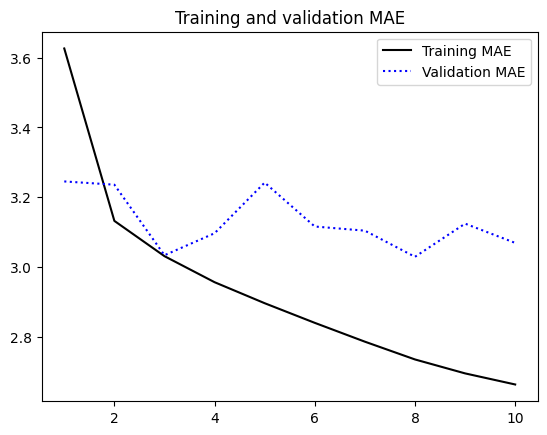

In [ ]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "k", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

As time goes on, both the training and validation losses decrease, indicating that the model is learning. It is common that the validation loss is somewhat greater than the training loss. To ensure that the model is not overfitting the training set, it is crucial to keep an eye on the validation loss. The model may not be properly generalizing to new data, as shown by the test MAE being considerably higher than the validation MAE. There are several possible reasons for this, including noise in the data or an undertrained model.

Simple RNN

In [ ]:

inputs = keras.Input(shape=(sequence_length,rawdata.shape[-1]))
x = layers.SimpleRNN(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_simRNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_simRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 43s 51ms/step - loss: 52.9995 - mae: 5.3694 - val_loss: 14.6349 - val_mae: 2.8383
Epoch 2/10
819/819 [==============================] - 41s 50ms/step - loss: 11.6335 - mae: 2.6397 - val_loss: 9.7661 - val_mae: 2.4029
Epoch 3/10
819/819 [==============================] - 42s 51ms/step - loss: 10.4455 - mae: 2.5218 - val_loss: 9.1918 - val_mae: 2.3517
Epoch 4/10
819/819 [==============================] - 41s 51ms/step - loss: 10.2375 - mae: 2.4963 - val_loss: 9.0385 - val_mae: 2.3346
Epoch 5/10
819/819 [==============================] - 42s 51ms/step - loss: 10.0988 - mae: 2.4803 - val_loss: 9.0541 - val_mae: 2.3339
Epoch 6/10
819/819 [==============================] - 42s 51ms/step - loss: 9.9803 - mae: 2.4653 - val_loss: 9.0666 - val_mae: 2.3394
Epoch 7/10
819/819 [==============================] - 42s 51ms/step - loss: 9.9064 - mae: 2.4538 - val_loss: 8.9535 - val_mae: 2.3229
Epoch 8/10
819/819 [==============================] - 41

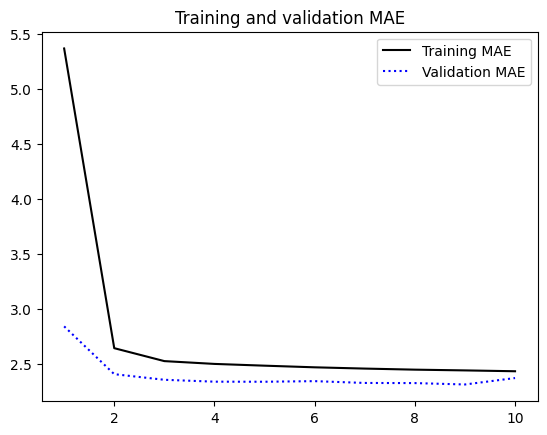

In [ ]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "k", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

Simple RNN

In [ ]:
number_features = 14
steps = 120
inputs = keras.Input(shape=(steps, number_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN1.st",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SRNN1.st")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 174s 209ms/step - loss: 137.0120 - mae: 9.5765 - val_loss: 143.4579 - val_mae: 9.8415
Epoch 2/10
819/819 [==============================] - 168s 205ms/step - loss: 135.9694 - mae: 9.5169 - val_loss: 143.4696 - val_mae: 9.8423
Epoch 3/10
819/819 [==============================] - 170s 208ms/step - loss: 135.9131 - mae: 9.5098 - val_loss: 143.4284 - val_mae: 9.8398
Epoch 4/10
819/819 [==============================] - 171s 208ms/step - loss: 135.8780 - mae: 9.5051 - val_loss: 143.3923 - val_mae: 9.8337
Epoch 5/10
819/819 [==============================] - 170s 208ms/step - loss: 135.8553 - mae: 9.5008 - val_loss: 143.3873 - val_mae: 9.8312
Epoch 6/10
819/819 [==============================] - 167s 204ms/step - loss: 135.8384 - mae: 9.4979 - val_loss: 143.3889 - val_mae: 9.8320
Epoch 7/10
819/819 [==============================] - 169s 207ms/step - loss: 135.8268 - mae: 9.4961 - val_loss: 143.3496 - val_mae: 9.8269
Epoch 8/10
819/819 [

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 120, 16)           496       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 120, 16)           528       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 16)                528       
                                                                 
Total params: 1552 (6.06 KB)
Trainable params: 1552 (6.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


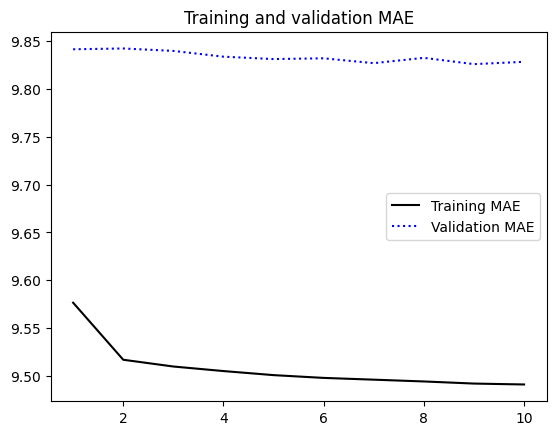

In [ ]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "k", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

GRU

In [ ]:
inputs = keras.Input(shape=(sequence_length, rawdata.shape[-1]))
x = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.st",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_gru.st")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 15s 16ms/step - loss: 41.2537 - mae: 4.6556 - val_loss: 13.0270 - val_mae: 2.7126
Epoch 2/10
819/819 [==============================] - 12s 15ms/step - loss: 10.8192 - mae: 2.5579 - val_loss: 9.6695 - val_mae: 2.4041
Epoch 3/10
819/819 [==============================] - 10s 12ms/step - loss: 9.8312 - mae: 2.4475 - val_loss: 10.3962 - val_mae: 2.4732
Epoch 4/10
819/819 [==============================] - 12s 15ms/step - loss: 9.3683 - mae: 2.3889 - val_loss: 9.2997 - val_mae: 2.3496
Epoch 5/10
819/819 [==============================] - 13s 16ms/step - loss: 9.0361 - mae: 2.3454 - val_loss: 9.1775 - val_mae: 2.3435
Epoch 6/10
819/819 [==============================] - 10s 12ms/step - loss: 8.7659 - mae: 2.3121 - val_loss: 9.4189 - val_mae: 2.3484
Epoch 7/10
819/819 [==============================] - 10s 12ms/step - loss: 8.4927 - mae: 2.2788 - val_loss: 9.7236 - val_mae: 2.3741
Epoch 8/10
819/819 [==============================] - 10s 

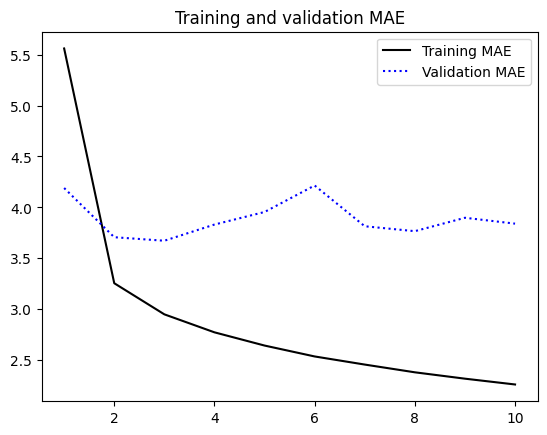

In [ ]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "k", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

LSTM

In [ ]:
inputs = keras.Input(shape=(sequence_length, rawdata.shape[-1]))
x = layers.LSTM(14)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.st",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.st")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 15s 16ms/step - loss: 50.6605 - mae: 5.2618 - val_loss: 16.2606 - val_mae: 3.0218
Epoch 2/10
819/819 [==============================] - 13s 16ms/step - loss: 12.1423 - mae: 2.6847 - val_loss: 10.0392 - val_mae: 2.4739
Epoch 3/10
819/819 [==============================] - 13s 16ms/step - loss: 10.1289 - mae: 2.4816 - val_loss: 9.8405 - val_mae: 2.4412
Epoch 4/10
819/819 [==============================] - 13s 16ms/step - loss: 9.7063 - mae: 2.4315 - val_loss: 9.6493 - val_mae: 2.4171
Epoch 5/10
819/819 [==============================] - 10s 12ms/step - loss: 9.4002 - mae: 2.3922 - val_loss: 9.7615 - val_mae: 2.4221
Epoch 6/10
819/819 [==============================] - 13s 16ms/step - loss: 9.0834 - mae: 2.3526 - val_loss: 9.6109 - val_mae: 2.4093
Epoch 7/10
819/819 [==============================] - 10s 12ms/step - loss: 8.7946 - mae: 2.3185 - val_loss: 9.7212 - val_mae: 2.4195
Epoch 8/10
819/819 [==============================] - 10s

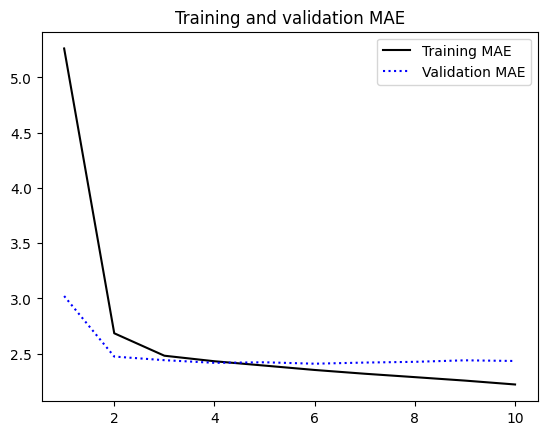

In [ ]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "k", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
inputs = keras.Input(shape=(sequence_length, rawdata.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 193s 231ms/step - loss: 44.7000 - mae: 4.9644 - val_loss: 12.9737 - val_mae: 2.7484
Epoch 2/10
819/819 [==============================] - 190s 231ms/step - loss: 19.8181 - mae: 3.4233 - val_loss: 10.1921 - val_mae: 2.4869
Epoch 3/10
819/819 [==============================] - 189s 231ms/step - loss: 18.2241 - mae: 3.2847 - val_loss: 9.8312 - val_mae: 2.4476
Epoch 4/10
819/819 [==============================] - 190s 232ms/step - loss: 17.4246 - mae: 3.2131 - val_loss: 9.4887 - val_mae: 2.4002
Epoch 5/10
819/819 [==============================] - 188s 230ms/step - loss: 16.7607 - mae: 3.1522 - val_loss: 9.8257 - val_mae: 2.4441
Epoch 6/10
819/819 [==============================] - 188s 230ms/step - loss: 16.3081 - mae: 3.1125 - val_loss: 9.5272 - val_mae: 2.4042
Epoch 7/10
819/819 [==============================] - 187s 229ms/step - loss: 15.9277 - mae: 3.0753 - val_loss: 9.5876 - val_mae: 2.4135
Epoch 8/10
819/819 [===================

405/405 [==============================] - 15s 37ms/step - loss: 10.8695 - mae: 2.6045
Test MAE: 2.60


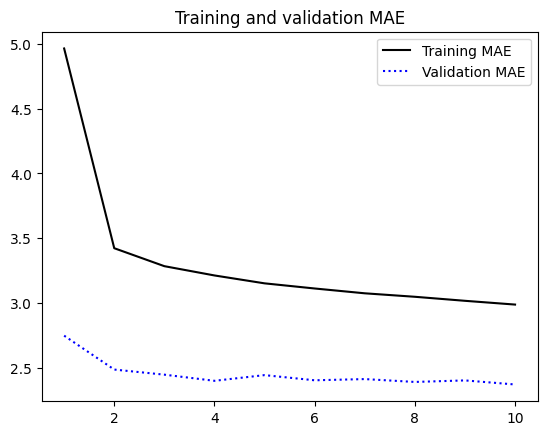

In [ ]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "k", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

LSTM-8 UNITS

In [ ]:
inputs = keras.Input(shape=(sequence_length, rawdata.shape[-1]))
x = layers.LSTM(8, return_sequences=True)(inputs)
x = layers.LSTM(8)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 23s 23ms/step - loss: 65.2742 - mae: 6.1312 - val_loss: 31.4657 - val_mae: 4.1297
Epoch 2/10
819/819 [==============================] - 19s 23ms/step - loss: 19.3788 - mae: 3.2590 - val_loss: 12.5710 - val_mae: 2.6822
Epoch 3/10
819/819 [==============================] - 19s 22ms/step - loss: 11.0020 - mae: 2.5668 - val_loss: 9.5676 - val_mae: 2.3997
Epoch 4/10
819/819 [==============================] - 19s 23ms/step - loss: 9.9002 - mae: 2.4511 - val_loss: 9.3623 - val_mae: 2.3848
Epoch 5/10
819/819 [==============================] - 19s 22ms/step - loss: 9.5883 - mae: 2.4159 - val_loss: 9.2140 - val_mae: 2.3686
Epoch 6/10
819/819 [==============================] - 19s 23ms/step - loss: 9.4030 - mae: 2.3937 - val_loss: 9.2013 - val_mae: 2.3642
Epoch 7/10
819/819 [==============================] - 14s 16ms/step - loss: 9.2449 - mae: 2.3766 - val_loss: 9.3889 - val_mae: 2.3698
Epoch 8/10
819/819 [==============================] - 14s

In [ ]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "k", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

LSTM-16 UNITS

In [ ]:
inputs = keras.Input(shape=(sequence_length, rawdata.shape[-1]))
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked1")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 23s 25ms/step - loss: 34.2840 - mae: 4.2316 - val_loss: 11.4710 - val_mae: 2.5803
Epoch 2/10
819/819 [==============================] - 19s 23ms/step - loss: 9.9795 - mae: 2.4532 - val_loss: 9.9654 - val_mae: 2.4499
Epoch 3/10
819/819 [==============================] - 14s 17ms/step - loss: 8.8150 - mae: 2.3169 - val_loss: 10.1058 - val_mae: 2.4637
Epoch 4/10
819/819 [==============================] - 19s 24ms/step - loss: 8.2178 - mae: 2.2403 - val_loss: 9.7238 - val_mae: 2.4178
Epoch 5/10
819/819 [==============================] - 14s 17ms/step - loss: 7.9035 - mae: 2.1981 - val_loss: 9.8572 - val_mae: 2.4364
Epoch 6/10
819/819 [==============================] - 14s 17ms/step - loss: 7.4735 - mae: 2.1351 - val_loss: 10.0586 - val_mae: 2.4628
Epoch 7/10
819/819 [==============================] - 14s 17ms/step - loss: 7.1261 - mae: 2.0858 - val_loss: 10.6629 - val_mae: 2.5446
Epoch 8/10
819/819 [==============================] - 14s

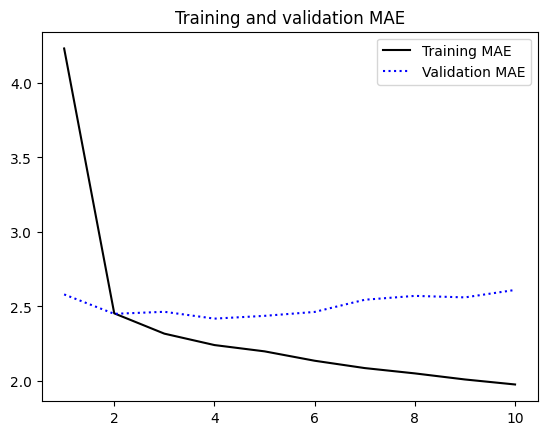

In [ ]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "k", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

LSTM-32 UNITS

In [ ]:
inputs = keras.Input(shape=(sequence_length, rawdata.shape[-1]))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked2")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 24s 26ms/step - loss: 19.8145 - mae: 3.2142 - val_loss: 10.3688 - val_mae: 2.5037
Epoch 2/10
819/819 [==============================] - 19s 23ms/step - loss: 8.2442 - mae: 2.2329 - val_loss: 10.3485 - val_mae: 2.5105
Epoch 3/10
819/819 [==============================] - 14s 17ms/step - loss: 6.7407 - mae: 2.0134 - val_loss: 11.3301 - val_mae: 2.6179
Epoch 4/10
819/819 [==============================] - 14s 17ms/step - loss: 5.6825 - mae: 1.8466 - val_loss: 12.6117 - val_mae: 2.7783
Epoch 5/10
819/819 [==============================] - 14s 17ms/step - loss: 4.9088 - mae: 1.7107 - val_loss: 12.2625 - val_mae: 2.7201
Epoch 6/10
819/819 [==============================] - 14s 17ms/step - loss: 4.2895 - mae: 1.5937 - val_loss: 12.9529 - val_mae: 2.8230
Epoch 7/10
819/819 [==============================] - 14s 17ms/step - loss: 3.8371 - mae: 1.5051 - val_loss: 13.8598 - val_mae: 2.9079
Epoch 8/10
819/819 [==============================] - 

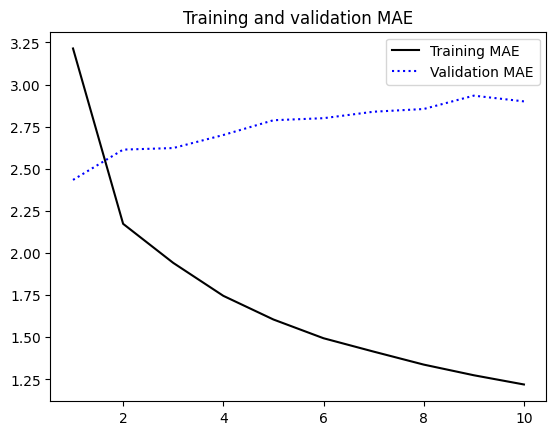

In [ ]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "k", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

LSTM-64 UNITS

In [ ]:
inputs = keras.Input(shape=(sequence_length, rawdata.shape[-1]))
x = layers.LSTM(64, return_sequences=True)(inputs)
x = layers.LSTM(64)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked3")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 24s 25ms/step - loss: 13.0238 - mae: 2.6572 - val_loss: 11.4974 - val_mae: 2.6641
Epoch 2/10
819/819 [==============================] - 15s 18ms/step - loss: 5.2677 - mae: 1.7694 - val_loss: 11.5814 - val_mae: 2.6550
Epoch 3/10
819/819 [==============================] - 14s 17ms/step - loss: 3.2282 - mae: 1.3745 - val_loss: 12.9637 - val_mae: 2.8472
Epoch 4/10
819/819 [==============================] - 14s 17ms/step - loss: 2.2655 - mae: 1.1423 - val_loss: 12.4392 - val_mae: 2.7666
Epoch 5/10
819/819 [==============================] - 14s 17ms/step - loss: 1.7835 - mae: 1.0090 - val_loss: 13.0927 - val_mae: 2.8451
Epoch 6/10
819/819 [==============================] - 14s 17ms/step - loss: 1.4434 - mae: 0.9078 - val_loss: 12.9769 - val_mae: 2.8213
Epoch 7/10
819/819 [==============================] - 14s 17ms/step - loss: 1.2099 - mae: 0.8313 - val_loss: 13.6660 - val_mae: 2.8887
Epoch 8/10
819/819 [==============================] - 

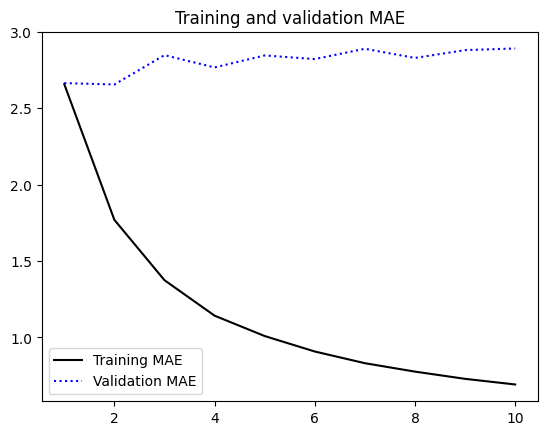

In [ ]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "k", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
inputs = keras.Input(shape=(sequence_length, rawdata.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(8, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 410s 496ms/step - loss: 67.0442 - mae: 6.2429 - val_loss: 29.4847 - val_mae: 4.0101
Epoch 2/10
819/819 [==============================] - 407s 497ms/step - loss: 29.7412 - mae: 4.0883 - val_loss: 13.0808 - val_mae: 2.7206
Epoch 3/10
819/819 [==============================] - 406s 496ms/step - loss: 24.1892 - mae: 3.7226 - val_loss: 11.3131 - val_mae: 2.5809
Epoch 4/10
819/819 [==============================] - 405s 494ms/step - loss: 22.5831 - mae: 3.6063 - val_loss: 10.3955 - val_mae: 2.4859
Epoch 5/10
819/819 [==============================] - 405s 494ms/step - loss: 21.1494 - mae: 3.4910 - val_loss: 9.9407 - val_mae: 2.4358
Epoch 6/10
819/819 [==============================] - 406s 496ms/step - loss: 20.1101 - mae: 3.4143 - val_loss: 9.8543 - val_mae: 2.4245
Epoch 7/10
819/819 [==============================] - 403s 491ms/step - loss: 19.4418 - mae: 3.3583 - val_loss: 10.3309 - val_mae: 2.4740
Epoch 8/10
819/819 [================

405/405 [==============================] - 29s 69ms/step - loss: 10.6470 - mae: 2.5430
Test MAE: 2.54


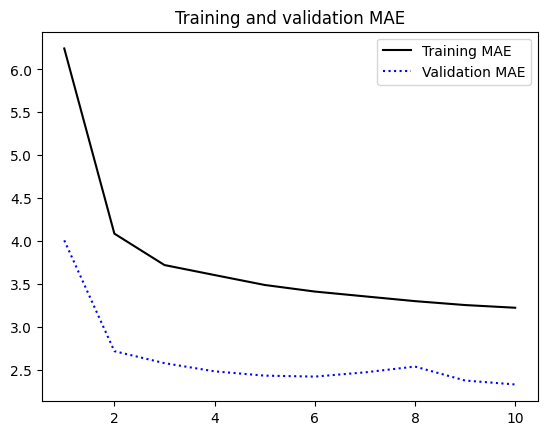

In [ ]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "k", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

Bi Directional

In [ ]:
inputs = keras.Input(shape=(sequence_length, rawdata.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                     callbacks=callbacks)

model = keras.models.load_model("jena_bidirec_LSTM")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 26s 28ms/step - loss: 25.5896 - mae: 3.6347 - val_loss: 10.1820 - val_mae: 2.4639
Epoch 2/10
819/819 [==============================] - 23s 28ms/step - loss: 9.4600 - mae: 2.3934 - val_loss: 9.5905 - val_mae: 2.3978
Epoch 3/10
819/819 [==============================] - 23s 28ms/step - loss: 8.5995 - mae: 2.2774 - val_loss: 9.4761 - val_mae: 2.3899
Epoch 4/10
819/819 [==============================] - 14s 17ms/step - loss: 8.0627 - mae: 2.2088 - val_loss: 9.8366 - val_mae: 2.4443
Epoch 5/10
819/819 [==============================] - 14s 17ms/step - loss: 7.6256 - mae: 2.1533 - val_loss: 10.0089 - val_mae: 2.4620
Epoch 6/10
819/819 [==============================] - 14s 17ms/step - loss: 7.2349 - mae: 2.1002 - val_loss: 10.1023 - val_mae: 2.4833
Epoch 7/10
819/819 [==============================] - 14s 17ms/step - loss: 6.9367 - mae: 2.0585 - val_loss: 10.3011 - val_mae: 2.5060
Epoch 8/10
819/819 [==============================] - 14s

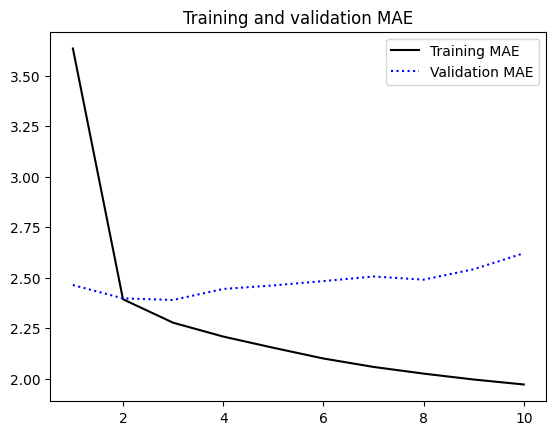

In [ ]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "k", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()


1D Convnets and LSTM

In [ ]:
inputs = keras.Input(shape=(sequence_length, rawdata.shape[-1]))
x = layers.Conv1D(64, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Reshape((-1, 128))(x)  # Reshape the data to be 3D
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM", save_best_only=True)
]

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_Conv_LSTM")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 16s 17ms/step - loss: 55.1601 - mae: 5.5606 - val_loss: 29.3414 - val_mae: 4.1901
Epoch 2/10
819/819 [==============================] - 12s 15ms/step - loss: 17.8893 - mae: 3.2550 - val_loss: 21.8039 - val_mae: 3.7068
Epoch 3/10
819/819 [==============================] - 12s 14ms/step - loss: 14.4047 - mae: 2.9494 - val_loss: 21.7717 - val_mae: 3.6723
Epoch 4/10
819/819 [==============================] - 9s 11ms/step - loss: 12.7442 - mae: 2.7727 - val_loss: 24.0593 - val_mae: 3.8313
Epoch 5/10
819/819 [==============================] - 9s 11ms/step - loss: 11.6200 - mae: 2.6428 - val_loss: 24.9909 - val_mae: 3.9546
Epoch 6/10
819/819 [==============================] - 9s 11ms/step - loss: 10.7688 - mae: 2.5357 - val_loss: 27.8894 - val_mae: 4.2149
Epoch 7/10
819/819 [==============================] - 9s 11ms/step - loss: 10.1090 - mae: 2.4561 - val_loss: 23.4389 - val_mae: 3.8145
Epoch 8/10
819/819 [==============================] 

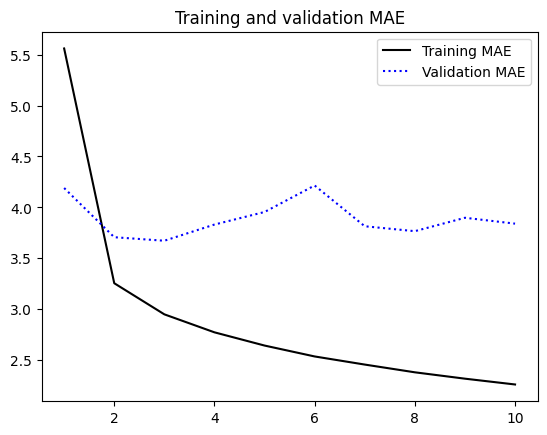

In [ ]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "k", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()


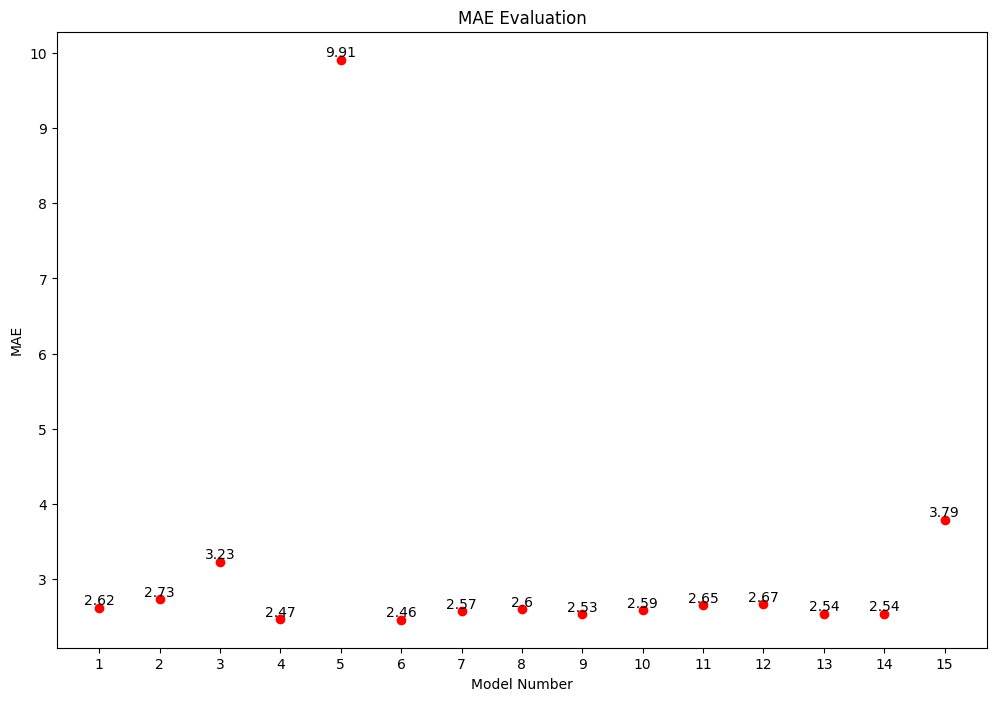

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13","14","15")
Mae = (2.62,2.73,3.23,2.47,9.91,2.46,2.57,2.60,2.53,2.59,2.65,2.67,2.54,2.54,3.79)

# MAE Evaluation
plt.figure(figsize=(12, 8))
plt.scatter(Models, Mae, color="red")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()